In [1]:
import os
import http
import copy
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores
from backwardcompatibilityml.helpers import training
from backwardcompatibilityml.widget.compatibility_analysis import CompatibilityAnalysis

# Turn off warnings so that the widget screen
# real estate does not decrease.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# age: continuous.
# workclass: (8) Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: (16) Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: (7) Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: (14) Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: (6) Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: (5) White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: (2) Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: (41) United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



In [3]:
if not os.path.isdir("datasets/adult-uci"):
    os.mkdir("datasets/adult-uci")

http_client = http.client.HTTPSConnection("archive.ics.uci.edu")
http_client.request("GET", "/ml/machine-learning-databases/adult/adult.data")
response = http_client.getresponse()
data = response.read().decode("utf-8")
data_file = open("datasets/adult-uci/adult.data", "w")
data_file.write(data)
data_file.close()

In [4]:
datafile = open("datasets/adult-uci/adult.data", "r")
raw_data = datafile.read()
datafile.close()

In [5]:
import pandas as pd
df = pd.read_csv("datasets/adult-uci/adult.data")

In [6]:
df.loc[10:20]

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
10,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
11,23,Private,122272,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,<=50K
12,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,<=50K
13,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
14,34,Private,245487,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,45,Mexico,<=50K
15,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
16,32,Private,186824,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,White,Male,0,0,40,United-States,<=50K
17,38,Private,28887,11th,7,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,<=50K
18,43,Self-emp-not-inc,292175,Masters,14,Divorced,Exec-managerial,Unmarried,White,Female,0,0,45,United-States,>50K
19,40,Private,193524,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,>50K


In [7]:
rows_with_header = list(map(lambda l: list(map(lambda ll: ll.strip(), l.split(","))), filter(lambda l: len(l) > 0, map(lambda l: l.strip(), raw_data.split("\n")))))
data_rows = rows_with_header[1:]
data_rows = list(filter(lambda r: ("?" not in r), data_rows))
# data_rows_transformed = list(map(lambda r: [torch.tensor(int(r[0]), dtype=torch.long), torch.tensor(list(map(lambda i: int(i), r[1:])), dtype=torch.float32)], data_rows))
# random.shuffle(data_rows_transformed)

In [8]:
def build_categorical_encoder(input_attribute_index, categories, total_dimensions, start_index, end_index):
    if not (end_index - start_index + 1 == len(categories)):
        raise Exception("Mismatch between number of categories and dimensions assigned.")
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        
        category_index = categories.index(data_row[input_attribute_index])
        encoding_index = start_index + category_index
        data_vector[encoding_index] = 1
    
    return encoder

def build_continuous_encoder(input_attribute_index, total_dimensions, attribute_index):
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        data_vector[attribute_index] = float(data_row[input_attribute_index])
    
    return encoder

def encode_data(rows, encoders, total_dimensions):
    encoded_rows = []
    for row in rows:
        encoded_row = [0] * total_dimensions
        for encoder in encoders:
            encoder(row, encoded_row)
        encoded_rows.append(encoded_row)
    
    return encoded_rows

In [9]:
total_dim = 105
workingclass_classes = ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"]
education_classes = ["Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool"]
maritalstatus_classes = ["Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]
occupation_classes = ["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"]
relationship_classes = ["Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried"]
race_classes = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
sex_classes = ["Female", "Male"]
nativecountry_classes = ["United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"]
income_classes = ["<=50K", ">50K"]


age_encoder = build_continuous_encoder(0, total_dim, 0)
workingclass_encoder = build_categorical_encoder(1, workingclass_classes, total_dim, 1, 8)
fnlwgt_encoder = build_continuous_encoder(2, total_dim, 9)
education_encoder = build_categorical_encoder(3, education_classes, total_dim, 10, 25)
educationnum_encoder = build_continuous_encoder(4, total_dim, 26)
maritalstatus_encoder = build_categorical_encoder(5, maritalstatus_classes, total_dim, 27, 33)
occupation_encoder = build_categorical_encoder(6, occupation_classes, total_dim, 34, 47)
relationship_encoder = build_categorical_encoder(7, relationship_classes, total_dim, 48, 53)
race_encoder = build_categorical_encoder(8, race_classes, total_dim, 54, 58)
sex_encoder = build_categorical_encoder(9, sex_classes, total_dim, 59, 60)
capitalgain_encoder = build_continuous_encoder(10, total_dim, 61)
capitalloss_encoder = build_continuous_encoder(11, total_dim, 62)
hoursperweek_encoder = build_continuous_encoder(12, total_dim, 63)
nativecountry_encoder = build_categorical_encoder(13, nativecountry_classes, total_dim, 64, 104)

data_encoders = [
    age_encoder,
    workingclass_encoder,
    fnlwgt_encoder,
    education_encoder,
    educationnum_encoder,
    maritalstatus_encoder,
    occupation_encoder,
    relationship_encoder,
    race_encoder,
    sex_encoder,
    nativecountry_encoder
]

income_encoder = build_categorical_encoder(14, income_classes, 2, 0, 1)

target_encoders = [income_encoder]


In [10]:
encoded_data_rows = encode_data(data_rows, data_encoders, total_dim)
encoded_target_rows = encode_data(data_rows, target_encoders, 2)
encoded_data = list(zip(encoded_data_rows, encoded_target_rows))
random.shuffle(encoded_data)

In [11]:
data_rows_transformed = list(map(lambda r: (torch.tensor(r[0]), torch.tensor(np.argmax(r[1]))), encoded_data))

In [12]:
int(0.8 * len(data_rows_transformed))

24128

In [13]:
training_set = data_rows_transformed[:24128]
testing_set = data_rows_transformed[24128:]

In [14]:
len(training_set), len(testing_set)

(24128, 6033)

In [15]:
n_epochs = 20
batch_size_train = 754
batch_size_test = 6033
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [16]:
train_loader = []
prev = 0
for i in range((batch_size_train - 1), len(training_set), batch_size_train):
    training_data = list(map(lambda r: r[0], training_set[prev:i]))
    training_labels = list(map(lambda r: r[1], training_set[prev:i]))
    prev = i
    train_loader.append([torch.stack(training_data, dim=0), torch.stack(training_labels, dim=0)])

test_loader = []
prev = 0
for i in range((batch_size_test - 1), len(testing_set), batch_size_test):
    testing_data = list(map(lambda r: r[0], testing_set[prev:i]))
    testing_labels = list(map(lambda r: r[1], testing_set[prev:i]))
    prev = i
    test_loader.append([torch.stack(testing_data, dim=0), torch.stack(testing_labels, dim=0)])

In [17]:
train_loader[0][0].size(), train_loader[0][1].size(), len(train_loader) * batch_size_train

(torch.Size([753, 105]), torch.Size([753]), 24128)

In [18]:
test_loader[0][0].size(), test_loader[0][1].size(), len(test_loader) * batch_size_test

(torch.Size([6032, 105]), torch.Size([6032]), 6033)

In [19]:
train_loader_a = train_loader[:int(len(train_loader)/2)]
train_loader_b = train_loader[int(len(train_loader)/2):]

In [20]:
from torch import nn, optim, tensor, cuda

from torch.nn import functional as F

 

class MLPClassifier(nn.Module):

    def __init__(self, input_size, num_classes, hidden_sizes=[50, 10]):
        super(MLPClassifier, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]

        for i, layer in enumerate(self.layers):
            self.add_module("layer-%d" % i, layer)

    def forward(self, data, sample_weight=None):
        x = data
        out = x 
        num_layers = len(self.layers)

        for i in range(num_layers):
            out = self.layers[i](out)
            if i < num_layers - 1:
                out = F.relu(out)

        out_softmax = F.softmax(out, dim=-1)
        out_log_softmax = F.log_softmax(out, dim=-1)

        return out, out_softmax, out_log_softmax


class LogisticRegression(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out_softmax = F.softmax(out, dim=-1)
        out_log_softmax = F.log_softmax(out, dim=-1)

        return out, out_softmax, out_log_softmax



In [21]:
network = LogisticRegression(105, 2)
# network = MLPClassifier(105, 2, hidden_sizes=[5])
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [22]:
train_counter, test_counter, train_losses, test_losses = training.train(
    n_epochs, network, optimizer, F.cross_entropy, train_loader, test_loader,
    batch_size_train, batch_size_test)

Text(0, 0.5, 'negative log likelihood loss')

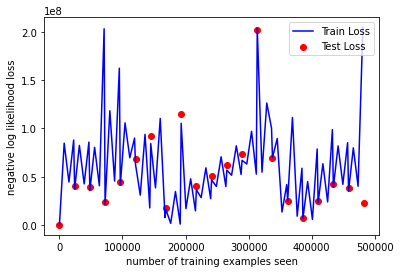

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [24]:
with torch.no_grad():
    _, _, output = network(test_loader[0][0])

In [25]:
from sklearn.metrics import accuracy_score

h1_accuracy = accuracy_score(output.data.max(1)[1].numpy(), test_loader[0][1].numpy())
h1_accuracy

0.7567970822281167

In [26]:
h1 = copy.deepcopy(network)

# analysis = CompatibilityAnalysis("sweeps", n_epochs, network, train_loader_b, test_loader,
#     batch_size_train, batch_size_test, learning_rate, momentum, lambda_c_stepsize=0.5)
# Here we are setting h2 to be a copy of h1 but in actuality,
# we could pass in any model as h2.
# h2 = MLPClassifier(105, 2, [80, 40, 20, 10])
h2 = LogisticRegression(105, 2)
# h2 = MLPClassifier(105, 2, [5])

analysis = CompatibilityAnalysis("sweeps-adult", n_epochs, h1, h2, train_loader, test_loader,
    batch_size_train, batch_size_test,
    OptimizerClass=optim.SGD,
    optimizer_kwargs={"lr": learning_rate, "momentum": momentum},
    NewErrorLossClass=bcloss.new_error.BCCrossEntropyLoss,
    StrictImitationLossClass=bcloss.StrictImitationCrossEntropyLoss,
    lambda_c_stepsize=0.25)